## Prepare Provider Maps 
* Clip each provider map to be California only
* Find the areas where the provider has *no coverage* using `find_difference_and_clip` in `utilities`.


In [1]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import pandas as pd
import shapely.wkt
import utilities
from calitp import *
from shared_utils import geography_utils, utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Load in Counties/Districts

In [2]:
counties = utilities.get_counties()

In [3]:
# Read in original CT map
ct_all_districts = to_snakecase(
        gpd.read_file(f"{utilities.caltrans_shape}").to_crs(epsg=4326)
    )[["district", "geometry"]]
    

### Load in Provider Maps
#### AT&T
* Complete. 
* Clipped to CA counties and `find difference and clip` function applied to AT&T's Map.
* Final df: `gs://calitp-analytics-data/data-analyses/cellular_coverage/att_all_counties.parquet`

#### Verizon 
* Crashes when clipping to Kern County
* Doesn't work at all with districts shapefile. Have to use CA counties. 
    * `breakout_counties` function in `utilities`.
* Solution: fix Kern county and concat it with the other files 
* Final result including the fixed Kern row: 
   * `gs://calitp-analytics-data/data-analyses/cellular_coverage/verizon_all_counties.parquet`

In [4]:
# Original map
# verizon = dg.read_parquet("Verizon.parquet")

In [5]:
# Fix Kern and add it 
# verizon_kern = utilities.find_difference_and_clip(verizon, kern)

In [6]:
# verizon_kern.plot()

#### T-Mobile
* The map that gives me the most trouble. 
* T Mobile includes several portions of other states, in addition to California.
* Have to clip it to California a different way than Verizon & AT&T in the sjoin step below.

In [7]:
# Original map
tmobile = dg.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_california.parquet"
)

##### Sjoin  for T-Mobile by Districts
* Do a sjoin to only grab rows of T-Mobile's gdf that overlap with Caltrans districts before `find difference and clip`.
* Counties didn't seem to work, that's why I went with districts.
* Done: Results are split between 3 parquets.
    * `gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_d1_d4.parquet` 
    * `gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_d5_d8.parquet`
    * `gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_d9_d12.parquet`

In [8]:
def district_sjoin(
    provider, gcs_file_path: str, file_name: str, districts_wanted: list
):

    # Original CT map
    ct_all_districts = to_snakecase(
        gpd.read_file(f"{utilities.caltrans_shape}").to_crs(epsg=4326)
    )[["district", "geometry"]]

    # Empty dataframe to hold each district after clipping
    full_gdf = pd.DataFrame()

    # Specify districts I want.
    for i in districts_wanted:
        district_gdf = ct_all_districts[ct_all_districts.district == i].reset_index(
            drop=True
        )

        # https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.GeoDataFrame.sjoin.html
        dask_sjoin = provider.sjoin(district_gdf, how="inner", predicate="intersects")
        full_gdf = dd.multi.concat([full_gdf, dask_sjoin], axis=0)
        print(f"Done concating for {i}")

    # Turn back to a regular gdf
    full_gdf = full_gdf.compute()

    # Save to GCS
    utils.geoparquet_gcs_export(full_gdf, gcs_file_path, file_name)
    print("Saved to GCS")

    return full_gdf

In [9]:
# test = district_sjoin(tmobile, utilities.GCS_FILE_PATH,'tmobile_d1_d4', [1,2,3,4])

In [10]:
# https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.GeoDataFrame.sjoin.html
# dask_sjoin = tmobile.sjoin(d4, how='inner', predicate='intersects')

In [11]:
# https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.GeoDataFrame.sjoin.html
# dask_sjoin2 = tmobile.sjoin(d7, how='inner', predicate='intersects')

In [12]:
# Multi concat
# dask_concat =  dd.multi.concat([dask_sjoin, dask_sjoin2], axis=0)

In [13]:
# Turn into normal df
# dask_concat_gdf = dask_concat.compute()

In [14]:
# dask_concat_gdf_dissolved = dask_concat_gdf.dissolve().drop(columns = ['district'])

In [15]:
# https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.GeoDataFrame.dissolve.html
# dask_concat_dissolve = dask_concat.dissolve("district")

In [16]:
# Find length of a dask df
# https://stackoverflow.com/questions/50569171/how-do-i-find-the-length-of-a-dataframe-in-dask
# print(len(dask_concat_dissolve.index))

##### HELP T-Mobile: find Districts w/o Coverage - Blocked
* T-Mobile giving me trouble: after filtering df for only one district I try to `find difference and clip` and `overlay` won't work - it keeps running forever.
    * `test1 = find_difference_and_clip(tmobile_d1_dg_gdf, ct_d1)` and `test2` are  the lines I'm having tgrouble with
* Dissolving just district 1 for T-Mobile vs not doesn't matter, neither works.

In [17]:
# Read in T Mobile coverage parquet
# The original provider map
tmobile_d1d4_dd = dg.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_d1_d4.parquet"
)[['geometry','district']]

In [18]:
type(tmobile_d1d4_dd)

dask_geopandas.core.GeoDataFrame

In [19]:
# Turn dask to gdf to check out it's info
tmobile_d1d4_dd_gdf = tmobile_d1d4_dd.compute()

In [20]:
# Check out how many rows & length 
tmobile_d1d4_dd_gdf.district.value_counts(), len(tmobile_d1d4_dd_gdf)

(2    29134
 1    16144
 3    15353
 4     9409
 Name: district, dtype: int64,
 70040)

In [21]:
# Filter for only district 1 
ct_d1 = ct_all_districts[ct_all_districts["district"].isin([1])].reset_index()

In [22]:
ct_d1 = ct_d1.dissolve('district').reset_index(drop = True)

In [23]:
type(ct_d1)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

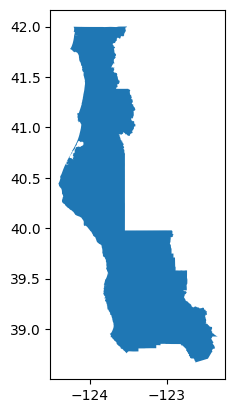

In [24]:
ct_d1.plot()

In [25]:
# Filter dask gdf for only d1 to test 
tmobile_d1_dg = tmobile_d1d4_dd[tmobile_d1d4_dd.district == 1].reset_index(drop = True)

In [26]:
type(tmobile_d1_dg)

dask_geopandas.core.GeoDataFrame

In [27]:
# Turn district 1 dask gdf to gdf just to test that it maps correctly
tmobile_d1_dg_gdf = tmobile_d1_dg.compute()

<AxesSubplot:>

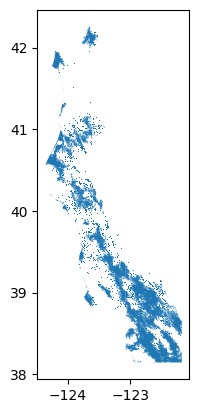

In [28]:
tmobile_d1_dg_gdf.plot()

In [29]:
tmobile_d1_dissolved = tmobile_d1_dg.dissolve('district')

In [30]:
# Same function as find difference and clip in the utilities
# However added print statements to see what step I'm on
def find_difference_and_clip(
    gdf: dg.GeoDataFrame, boundary: gpd.GeoDataFrame
) -> gpd.GeoDataFrame:
    # Clip cell provider to some boundary
    clipped = dg.clip(gdf, boundary).reset_index(drop=True)  # use dask to clip
    print('done clipping')
    
    clipped_gdf = clipped.compute()  # compute converts from dask gdf to gdf
    print('done computing')
    # Now find the overlay, and find the difference
    # Notice which df is on the left and which is on the right
    # https://geopandas.org/en/stable/docs/user_guide/set_operations.html
    no_coverage = gpd.overlay(boundary, clipped_gdf, how="difference",  keep_geom_type=False)
    print('done overlay')
    return no_coverage

In [31]:
test1 = find_difference_and_clip(tmobile_d1_dg, ct_d1)

done clipping
done computing


KeyboardInterrupt: 

In [ ]:
test2 = find_difference_and_clip(tmobile_d1_dissolved, ct_d1)

##### Function - once it works...hopefully

In [ ]:
def breakout_districts(
    provider: dg.GeoDataFrame,
    districts_wanted: list,
    gcs_file_path: str,
    file_name: str,
):
    # Read in original CT map
    ct_all_districts = to_snakecase(
        gpd.read_file(f"{utilities.caltrans_shape}").to_crs(epsg=4326)
    )[["district", "geometry"]]
    
    # Empty dataframe to hold each district after clipping
    full_gdf = pd.DataFrame()
    
    # Find difference and clip 
    for i in districts_wanted:
        
        provider = provider[provider.district == i].reset_index(drop = True)
        boundary = ct_all_districts[ct_all_districts.district == i].reset_index(drop=True)

        clipped = utilities.find_difference_and_clip(provider, boundary)
        print("Done finding difference for {i}")
        
        full_gdf = dd.multi.concat([full_gdf, clipped], axis=0)
        print(f"Done concating for {i}")

    # Turn this into a GDF
    full_gdf = full_gdf.compute()
    
    # Save to GCS
    utils.geoparquet_gcs_export(county_gdf_clipped, gcs_file_path, file_name)
    print("saved to GCS")
    
    return county_gdf_clipped

In [ ]:
# test = breakout_districts(tmobile_d1d4_dd, [1], utilities.GCS_FILE_PATH, "tmobile_no_coverage_d1")

### Stack all separated out areas using dask into 1 gdf
* All the provider maps after `find difference and clip` are split into different files.
* Piece them back together to create an gdf with the entirety of California.
* Applied this function to create AT&T and Verizon map.

In [ ]:
# California is separated out into different gdfs that contain
# portions of districts/counties. Concat them all together
# to get the entirety of California again.
def concat_all_areas(all_gdf: list, gcs_file_path: str, file_name: str):

    # Empty dataframe
    full_gdf = pd.DataFrame()

    # Concat all the districts that were broken out into one
    full_gdf = dd.multi.concat(all_gdf, axis=0)

    # Turn it into a gdf
    full_gdf = full_gdf.compute()

    # Export
    utils.geoparquet_gcs_export(full_gdf, gcs_file_path, file_name)

    print("Saved to GCS")
    return full_gdf

In [ ]:
# tmobile_all_CA = concat_all_areas(tmobile, utilities.GCS_FILE_PATH, "tmobile_overlap_with_CA")

In [ ]:
#verizon_wo_kern = gpd.read_parquet(
  # "gs://calitp-analytics-data/data-analyses/cellular_coverage/verizon_all_counties_except_Kern.parquet"
#)

In [ ]:
# verizon_wo_kern.plot()

In [ ]:
#verizon_all = gpd.read_parquet(
    #"gs://calitp-analytics-data/data-analyses/cellular_coverage/verizon_all_counties.parquet"
#)

In [ ]:
# verizon_all.plot()